## Plot loss for fixed network parameters

In [1]:
import os
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
import datetime



In [2]:
now = datetime.datetime.now()

# NAME OF FOLDER TO SAVE RESULTS
save_dir = 'results_2lay_tanh_inter{}'.format(now.strftime("%d_%H-%M"))

In [3]:
save_dir

'results_2lay_tanh_inter15_10-39'

In [4]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Generate data

In [5]:
# Helper to plot decision boundary

def plot_decision_boundary(pred_func, save_dir):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.reshape(xx.shape).detach().numpy()
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.savefig(save_dir+'/decision_bound.pdf')

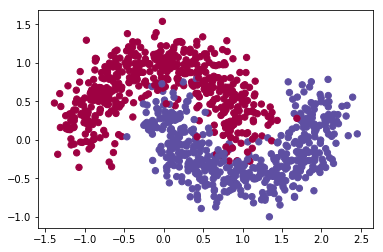

In [6]:

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)

X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

train = torch.utils.data.TensorDataset(X_torch[:800], y_torch[:800])
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=False)

test = torch.utils.data.TensorDataset(X_torch[800:], y_torch[800:])
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)

dataloader_dicts = {'train':train_loader, 'val':test_loader}

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

### Define model

In [7]:
# Regular FF, FC network

class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 3, bias=True)
        self.fc3 = nn.Linear(3, 1, bias=True)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)).view(-1, )
        return x


#### Training function

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = outputs>=0.5

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.byte())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

#### Model

In [9]:



net = simpleNet()
criterion = nn.BCELoss()



#### Only run if training

In [10]:
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
net, hist = train_model(net, dataloader_dicts, criterion, optimizer, num_epochs=num_epochs)
#torch.save(net.state_dict(), save_dir+'/mini_net.pt')


Epoch 0/9
----------
train Loss: 0.6407 Acc: 0.6262
val Loss: 0.5798 Acc: 0.8050

Epoch 1/9
----------
train Loss: 0.4913 Acc: 0.8213
val Loss: 0.4031 Acc: 0.8200

Epoch 2/9
----------
train Loss: 0.3577 Acc: 0.8525
val Loss: 0.3342 Acc: 0.8450

Epoch 3/9
----------
train Loss: 0.3157 Acc: 0.8650
val Loss: 0.3136 Acc: 0.8750

Epoch 4/9
----------
train Loss: 0.3155 Acc: 0.8538
val Loss: 0.3119 Acc: 0.8800

Epoch 5/9
----------
train Loss: 0.3102 Acc: 0.8612
val Loss: 0.3107 Acc: 0.8650

Epoch 6/9
----------
train Loss: 0.3025 Acc: 0.8638
val Loss: 0.3062 Acc: 0.8650

Epoch 7/9
----------
train Loss: 0.3016 Acc: 0.8625
val Loss: 0.3067 Acc: 0.8550

Epoch 8/9
----------
train Loss: 0.3001 Acc: 0.8650
val Loss: 0.3057 Acc: 0.8600

Epoch 9/9
----------
train Loss: 0.2984 Acc: 0.8650
val Loss: 0.3036 Acc: 0.8550

Training complete in 0m 0s
Best val Acc: 0.880000


/Users/mr54725/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [11]:
torch.save(net.state_dict(), save_dir+'/mini_net.pt')


## VIEW RESULTS

In [12]:
net.load_state_dict(torch.load(save_dir+'/mini_net.pt'))
NUM_PARAMS = 0
for w in net.parameters():
    NUM_PARAMS+=w.numel()

In [13]:
initial_loss = criterion(net(X_torch[:800]), y_torch[:800])

/Users/mr54725/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [14]:
initial_loss

tensor(0.3098, grad_fn=<BinaryCrossEntropyBackward>)

#### PLOT MAGNITUDES

/Users/mr54725/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


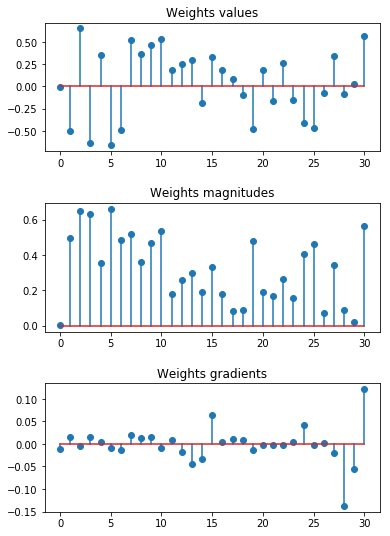

In [13]:


weights = torch.cat([w.contiguous().view(-1) for w in net.parameters()])
loss = criterion(net(X_torch[:800]), y_torch[:800])
grads_loss = torch.autograd.grad(loss, net.parameters(), create_graph=True)
flat_grad = torch.cat([w.contiguous().view(-1) for w in grads_loss]).detach().numpy()


fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(6,9))

ax1.stem(weights.detach().numpy(),  label="weight values")
ax1.set_title('Weights values')
ax2.stem(np.abs(weights.detach().numpy()))
ax2.set_title('Weights magnitudes')
ax3.stem(flat_grad)
ax3.set_title('Weights gradients')
plt.subplots_adjust(hspace=0.4)

plt.savefig(save_dir+'/weights_mags.pdf')
plt.show()

In [14]:
pretrain_model_path = save_dir+'/mini_net.pt'

In [15]:
# Function that computes change in train loss for perturbations
def move_param(i, net, perturbations):
    loss=[]
    accs = []
    param = net.state_dict()
    w  = torch.cat([w.contiguous().view(-1) for w in net.parameters()])
    w0 = w[i].item()
    for eps in perturbations:
        #print(criterion(net(X_torch[:800]), y_torch[:800]).item())
        w[i] =w0+eps
        prev = 0
        for key, value in param.items():
            num = value.numel()
            param[key] = torch.reshape(w[prev:(prev+num)], value.shape)
            prev = (prev+num)
        net.load_state_dict(param)
        outputs = net(X_torch[:800])
        val = criterion(outputs, y_torch[:800])
        preds = outputs>=0.5
        
        running_corrects = torch.sum(preds == y_torch[:800].byte())
        ac = running_corrects.double() / len(preds)
        #print(val.item())
        loss.append(val.item())
        accs.append(ac.item())
        net.load_state_dict(torch.load(pretrain_model_path))
    return(loss,accs )

In [16]:
all_params = []
perturbations = [i/10 for i in range(-10,10)]
for i in range(NUM_PARAMS):
    val = move_param(i, net, perturbations)
    all_params.append(val)

/Users/mr54725/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [17]:
# ADJUST NUMBER OF cols

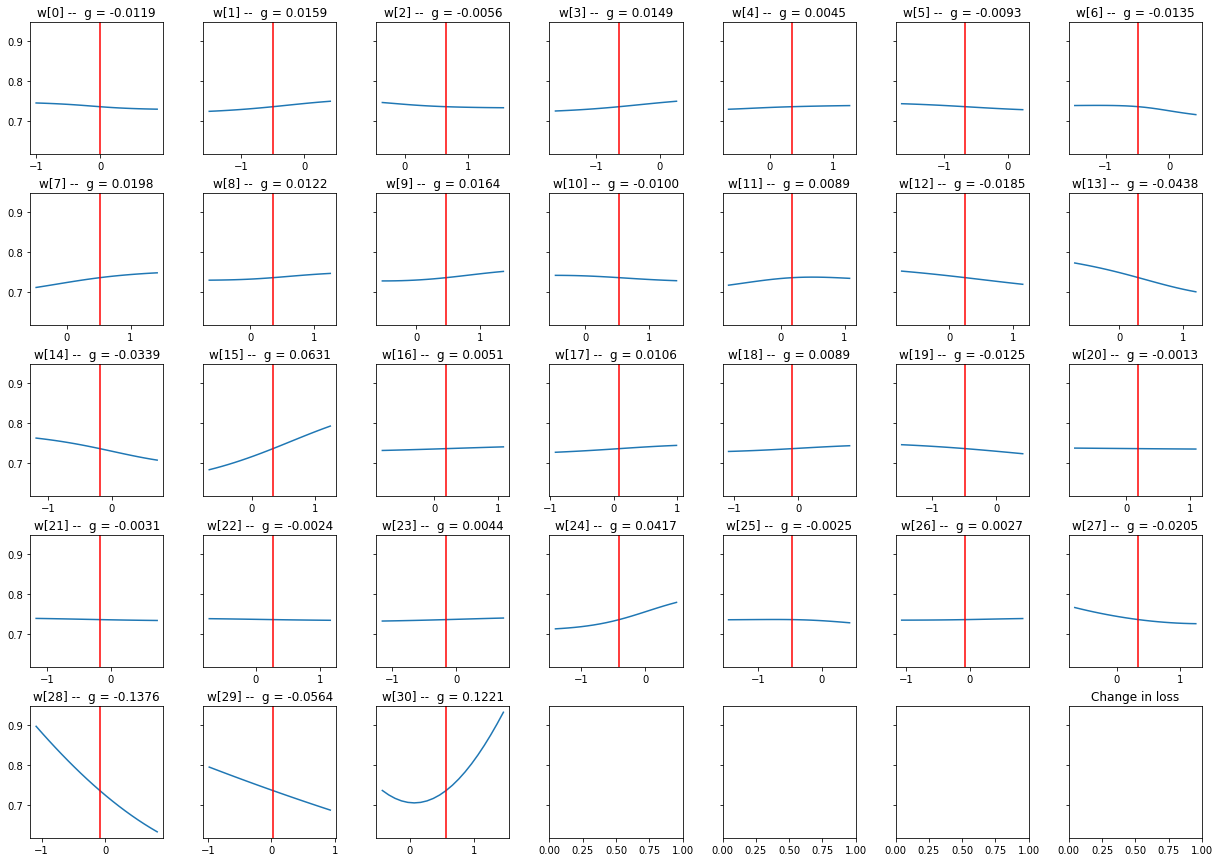

In [18]:
# Plot change in Loss
cols = 7
rows = ((NUM_PARAMS-1)//cols)+1
fig, ax = plt.subplots(rows,cols, figsize=(3*cols, 3*rows), sharey=True)


for i,ws in enumerate(all_params):
    val = ws[0]
    row = i //cols
    col = i %cols
    xs = np.array(perturbations)+weights[i].item()
    ax[row,col].plot(xs,val,  label="weight values")

    ax[row,col].set_title('w[{}] --  g = {:.4f}'.format(i, flat_grad[i]))
    ax[row, col].axvline(x=weights[i].item(), color = 'red')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.title('Change in loss')
plt.savefig(save_dir+'/change_loss.pdf')
plt.show()

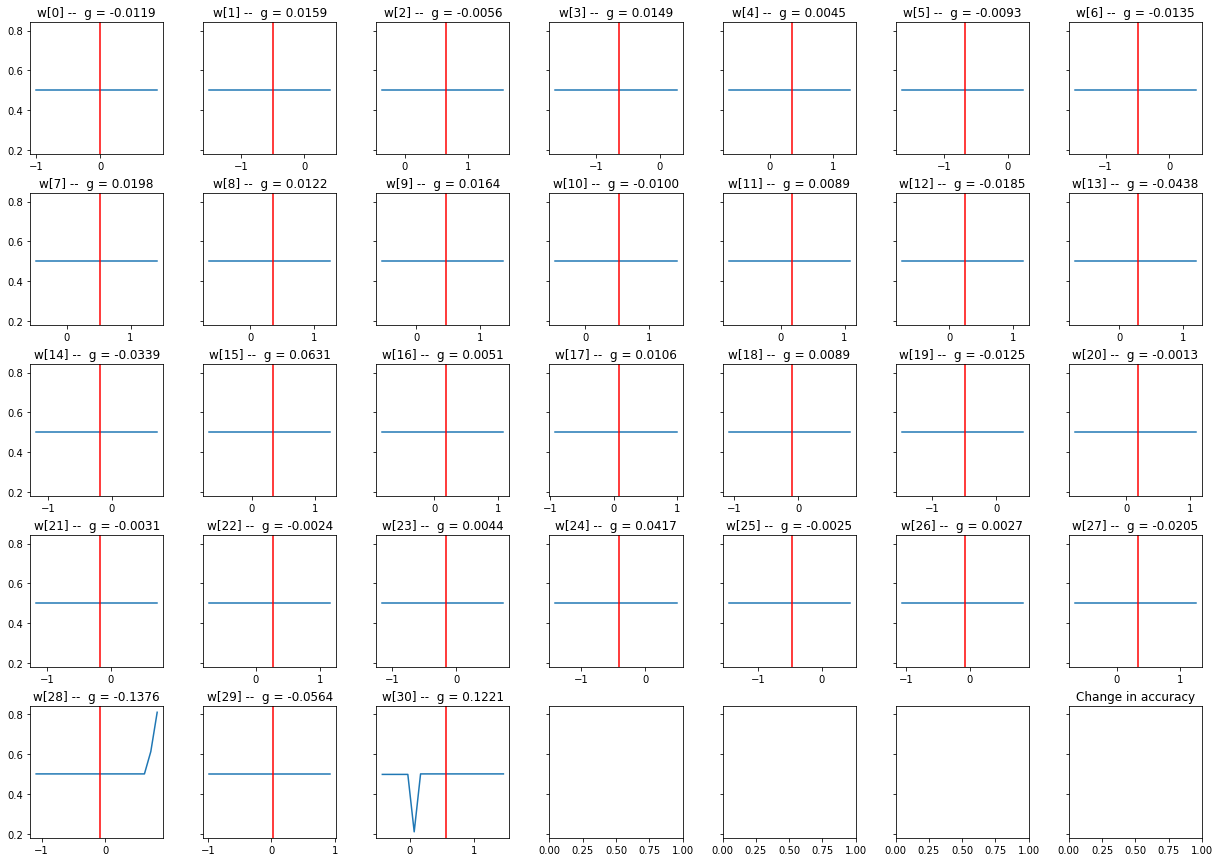

In [19]:
# Plot change in accuracy
cols = 7
rows = ((NUM_PARAMS-1)//cols)+1
fig, ax = plt.subplots(rows,cols, figsize=(3*cols, 3*rows), sharey=True)


for i,ws in enumerate(all_params):
    val = ws[1]
    row = i //cols
    col = i %cols
    xs = np.array(perturbations)+weights[i].item()
    ax[row,col].plot(xs,val,  label="weight values")

    ax[row,col].set_title('w[{}] --  g = {:.4f}'.format(i, flat_grad[i]))
    ax[row, col].axvline(x=weights[i].item(), color = 'red')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.title('Change in accuracy')
plt.savefig(save_dir+'/change_acc.pdf')
plt.show()

/Users/mr54725/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


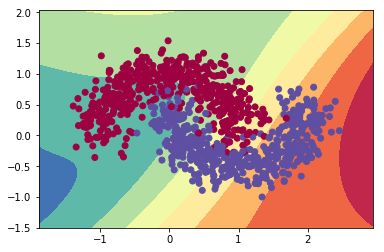

In [20]:
plot_decision_boundary(pred_func=net, save_dir = save_dir)